### 使用逻辑回归来评估页面分割好坏
#### The Data
我们建立一个回归模型，来评估我们页面切割方式是否够好

In [1]:
FILE_NAME = 'result_20190921.xlsx'
SHEET_NAME = 'Sheet1'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
path = 'data' + os.sep + FILE_NAME
pdData = pd.read_excel(path, sheet_name=SHEET_NAME)
pdData.head()

,URL,Xpath,Completeness,ActualCompleteness,Purity,CompletenessGain,NumberOfRooms,RoomClass,RoomType,RoomSize,BedType,Wheelchair,Smoking,View,ExtraAttributes,Score,Admitted
0,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
1,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
2,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2],5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
3,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2]/div,5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0
4,https://www.oyorooms.com/id/40374-oyo-rooms-oy...,/html/body/div[2]/div/div[3],5.0,0.83,0.0,0.0,0.1,Standard,Double Room,187 sqft,Double,0.0,unknown,View,"ac,tv,wifi",0.93,0.0


In [3]:
pdData.shape

(10726, 17)

In [4]:
# 数据预处理
pdData = pdData.dropna(axis = 0,how='any')
pdData = pdData.drop(['URL', 'Xpath', 'Completeness', 'RoomClass', 'RoomType', 'RoomSize', 'BedType', 'Wheelchair', 'Smoking', 'View', 'ExtraAttributes', 'Score'], axis=1)
pdData.shape

(10710, 5)

In [5]:
pdData.head(5)

,ActualCompleteness,Purity,CompletenessGain,NumberOfRooms,Admitted
0,0.83,0.0,0.0,0.1,0.0
1,0.83,0.0,0.0,0.1,0.0
2,0.83,0.0,0.0,0.1,0.0
3,0.83,0.0,0.0,0.1,0.0
4,0.83,0.0,0.0,0.1,0.0


## The logistic regression

目标：建立分类器（求解出三个参数 $\theta_0         \theta_1         \theta_2 $）


设定阈值，根据阈值判断录取结果

### 要完成的模块
-  `sigmoid` : 映射到概率的函数

-  `model` : 返回预测结果值

-  `cost` : 根据参数计算损失

-  `gradient` : 计算每个参数的梯度方向

-  `descent` : 进行参数更新

-  `accuracy`: 计算精度

### sigmoid 函数

$$g(z) = \frac{ 1 }{ 1 + e^{-z} }$$

In [6]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

### Sigmoid
* $g:\mathbb{R} \to [0,1]$
* $g(0)=0.5$
* $g(- \infty)=0$
* $g(+ \infty)=1$

In [7]:
def model(X, theta):
    return sigmoid(np.dot(X, theta.T))

$$
\begin{array}{ccc}
\begin{pmatrix}1 & x_{1} & x_{2} & x_{3} & x_{4} \end{pmatrix} & \times & \begin{pmatrix}
\theta_{0}\\
\theta_{1}\\
\theta_{3}\\
\theta_{4}\\
\theta_{5}
\end{pmatrix}\end{array}=\theta_{0}+\theta_{1}x_{1}+\theta_{2}x_{2}+\theta_{3}x_{3}+\theta_{4}x_{4}
$$

In [8]:
# 在第一列插入一个常数项1
pdData.insert(0, 'Ones', 1)

# set X (training data) and y (target variable)
# 将pandas的DataFrame 转 Numpy Array
orig_data = pdData.as_matrix()
cols = orig_data.shape[1]
X = orig_data[:,0:cols-1]
y = orig_data[:,cols-1:cols]

# initalize the parameter array theta
theta = np.zeros([1, 5])

/Users/hiCore/miniconda3/envs/python3.7.3_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [9]:
X[:5]

array([[1.  , 0.83, 0.  , 0.  , 0.1 ],
       [1.  , 0.83, 0.  , 0.  , 0.1 ],
       [1.  , 0.83, 0.  , 0.  , 0.1 ],
       [1.  , 0.83, 0.  , 0.  , 0.1 ],
       [1.  , 0.83, 0.  , 0.  , 0.1 ]])

In [10]:
y[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [11]:
theta

array([[0., 0., 0., 0., 0.]])

In [12]:
X.shape, y.shape, theta.shape

((10710, 5), (10710, 1), (1, 5))

### 损失函数
将对数似然函数去负号

$$
D(h_\theta(x), y) = -y\log(h_\theta(x)) - (1-y)\log(1-h_\theta(x))
$$
求平均损失
$$
J(\theta)=\frac{1}{n}\sum_{i=1}^{n} D(h_\theta(x_i), y_i)
$$

In [13]:
def cost(X, y, theta):
    left = np.multiply(-y, np.log(model(X, theta)))
    right = np.multiply(1 - y, np.log(1 - model(X, theta)))
    return np.sum(left - right) / (len(X))

In [14]:
cost(X, y, theta)

0.6931471805599453

### 计算梯度


$$
\frac{\partial J}{\partial \theta_j}=-\frac{1}{m}\sum_{i=1}^n (y_i - h_\theta (x_i))x_{ij}
$$

In [15]:
def gradient(X, y, theta):
    # 梯度 站位
    grad = np.zeros(theta.shape)
    error = (model(X, theta)- y).ravel()
    for j in range(len(theta.ravel())): #for each parmeter
        term = np.multiply(error, X[:,j])
        grad[0, j] = np.sum(term) / len(X)
    
    return grad

### Gradient descent

比较3中不同梯度下降方法

- 批量梯度下降（容易得到最优解，但每次考虑所有样本，速度很慢）
- 随机梯度下降（每次找一个样本，迭代速度快，但不一定每次都朝着收敛的方向）
- 小批量梯度下降（每次更新选择一小部分数据来算，实用）

In [16]:
STOP_ITER = 0
# 当没有损失或损失很小时停止
STOP_COST = 1
# 当梯度很小时停止
STOP_GRAD = 2

def stopCriterion(type, value, threshold):
    #设定三种不同的停止策略
    if type == STOP_ITER:        return value > threshold
    elif type == STOP_COST:      return abs(value[-1]-value[-2]) < threshold
    elif type == STOP_GRAD:      return np.linalg.norm(value) < threshold

In [17]:
# 数据进行洗牌，对数据进行打乱
import numpy.random
#洗牌
def shuffleData(data):
    np.random.shuffle(data)
    cols = data.shape[1]
    X = data[:, 0:cols-1]
    y = data[:, cols-1:]
    return X, y

In [18]:
import time

def descent(data, theta, batchSize, stopType, thresh, alpha):
    #梯度下降求解
    init_time = time.time()
    i = 0 # 迭代次数
    k = 0 # batch
    X, y = shuffleData(data)
    grad = np.zeros(theta.shape) # 计算的梯度
    costs = [cost(X, y, theta)] # 损失值

    
    while True:
        grad = gradient(X[k:k+batchSize], y[k:k+batchSize], theta)
        k += batchSize #取batch数量个数据
        if k >= n: 
            k = 0 
            X, y = shuffleData(data) #重新洗牌
        theta = theta - alpha*grad # 参数更新
        costs.append(cost(X, y, theta)) # 计算新的损失
        i += 1 

        if stopType == STOP_ITER:       value = i
        elif stopType == STOP_COST:     value = costs
        elif stopType == STOP_GRAD:     value = grad
        if stopCriterion(stopType, value, thresh): break
    
    return theta, i-1, costs, grad, time.time() - init_time

In [19]:
# batchSize 如果指定成1，就是随机梯度下降， 如果指定成总样本数，就是梯度下降  如果指定成 1-总样本数之间则是mini batch梯度下降
# stopType 是停止策略
# thresh 是阈值
# alpha 是学习率
def runExpe(data, theta, batchSize, stopType, thresh, alpha):
    #import pdb; pdb.set_trace();
    theta, iter, costs, grad, dur = descent(data, theta, batchSize, stopType, thresh, alpha)
    name = "Original" if (data[:,1]>2).sum() > 1 else "Scaled"
    name += " data - learning rate: {} - ".format(alpha)
    if batchSize==n: strDescType = "Gradient"
    elif batchSize==1:  strDescType = "Stochastic"
    else: strDescType = "Mini-batch ({})".format(batchSize)
    name += strDescType + " descent - Stop: "
    if stopType == STOP_ITER: strStop = "{} iterations".format(thresh)
    elif stopType == STOP_COST: strStop = "costs change < {}".format(thresh)
    else: strStop = "gradient norm < {}".format(thresh)
    name += strStop
    print ("***{}\nTheta: {} - Iter: {} - Last cost: {:03.2f} - Duration: {:03.2f}s".format(
        name, theta, iter, costs[-1], dur))
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(np.arange(len(costs)), costs, 'r')
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Cost')
    ax.set_title(name.upper() + ' - Error vs. Iteration')
    return theta

### 不同的停止策略

In [20]:
#### 设定迭代次数

***Scaled data - learning rate: 1e-06 - Gradient descent - Stop: 5000 iterations
Theta: [[-0.00238578 -0.0015026  -0.00102879 -0.00025491 -0.00101057]] - Iter: 5000 - Last cost: 0.69 - Duration: 61.40s


array([[-0.00238578, -0.0015026 , -0.00102879, -0.00025491, -0.00101057]])

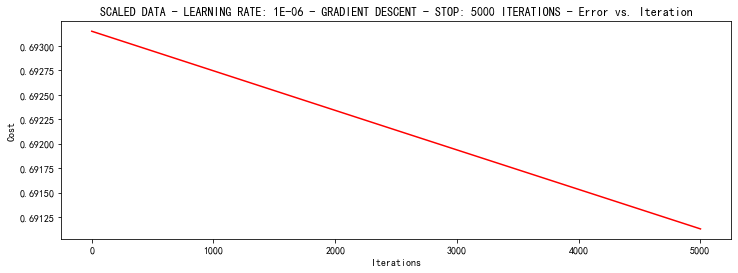

In [23]:
#选择的梯度下降方法是基于所有样本的
n=len(X)
theta = runExpe(orig_data, theta, n, STOP_ITER, thresh=5000, alpha=0.000001)

#### 根据损失值停止

设定阈值 1E-6, 差不多需要17 500次迭代 

***Scaled data - learning rate: 0.001 - Gradient descent - Stop: costs change < 1e-06
Theta: [[-1.77761761 -1.10767237 -0.5782684  -0.08959902 -0.66568096]] - Iter: 18237 - Last cost: 0.12 - Duration: 233.71s


array([[-1.77761761, -1.10767237, -0.5782684 , -0.08959902, -0.66568096]])

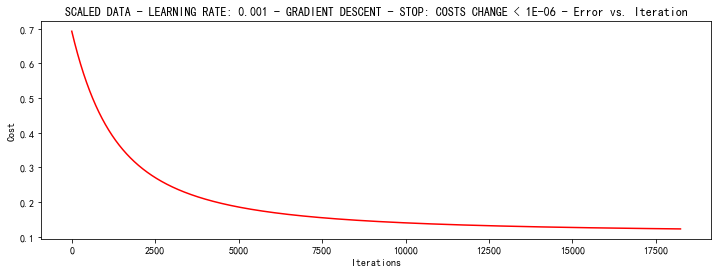

In [21]:
n=len(X)
theta = runExpe(orig_data, theta, n, STOP_COST, thresh=0.000001, alpha=0.001)

## 精度

In [22]:
#设定阈值
def predict(X, theta):
    return [1 if x >= 0.5 else 0 for x in model(X, theta)]

In [52]:
theta = np.array([[6.39, 4.66, 3.75, -1.07]])
from sklearn import preprocessing as pp
import numpy as np
scaled_data = orig_data.copy()
scaled_X = scaled_data[:, :5]
y = scaled_data[:, 5]
predictions = predict(scaled_X, theta)
correct = [
    1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0
    for (a, b) in zip(predictions, y)
]
accuracy = (sum(map(int, correct)) / len(correct))
print('accuracy = {0}%'.format(accuracy * 100))

accuracy = 97.75910364145658%
